# Research course notebook submission

**Name:** Abhijith Sreesylesh Babu

**Paper:** Fast Axiomatic Attribution for Neural Networks

### Fast Axiomatic Attribution

This paper discusses the attribution of input features based the behaviour of a deep neural network. In a previous paper about Integrated Gradients, the authors mentioned five axioms - sensitivity, implementation invariance, completeness, linearity and symmetry preserving.

The existing faster attribution methods fails to satisfy all the axioms. The methods that satisfy the axioms usually have very high computatinal cost. In this paper, they introduce X-gradient which can compute the attributes with a single forward/backward pass while satisfying the axioms

### X-gradients

X-gradient is an effective tool for attribution of images. This method can only be applied to a special class of DNNs called X-DNNs. X-DNNs are those DNNs that satisfy non-negative homogenity.

In this experiment, we create X-DNN from a DNN by removing the bias from the sequential layers. 

### Approach

Here I used VGG19 model from torchvision models for image classification. The idea is to remove the bias from the sequential layers in the network and do a forwad and backward pass. The gradients on input features will then be multiplied with the input image to get the attributions.

In addition to that, we vary the contrast of the image and see how the attributions are affected with the change

In [1]:
# Importing the necessary libraries

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import contextlib
from tqdm import tqdm
import torchvision.transforms.functional as TF


In [2]:
# Importing the vgg19 model

vgg19 = models.vgg19(pretrained=True)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Creating a x-dnn from vgg19

class X_VGG19(nn.Module):
    def __init__(self):
        super(X_VGG19, self).__init__()
        self.features = vgg19.features
        self.avgpool = vgg19.avgpool
        self.classifier = nn.Sequential(
            *(nn.Linear(layer.in_features, layer.out_features, bias=False) if isinstance(layer, nn.Linear) else layer
              for layer in vgg19.classifier)  
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
x_vgg19 = X_VGG19()
with open(os.devnull, 'w') as fnull:
    with contextlib.redirect_stdout(fnull):
        x_vgg19.eval()

In [4]:
# Images used in this experiment

image_list = [
    ["images/hen.jpg", 8],
    ["images/cup.jpg", 968],
    ["images/hammer.jpg", 587],
    ["images/violin.jpg", 889]
]

In [5]:
# function to calculate the x-gradients

def x_gradient(image, class_num):
    x_vgg19.zero_grad()
    image.retain_grad()
    class_scores = x_vgg19(image)
    target_score = class_scores[0, class_num]
    target_score.backward(retain_graph=True)
    gradients = image.grad.data
    attributions = image * gradients
    
    #Normalizing the attributions
    attributions = attributions.squeeze().detach().numpy()
    attributions = np.abs(attributions).sum(axis=0)
    attributions = (attributions - np.min(attributions)) / (np.max(attributions) - np.min(attributions))
    
    return attributions

100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


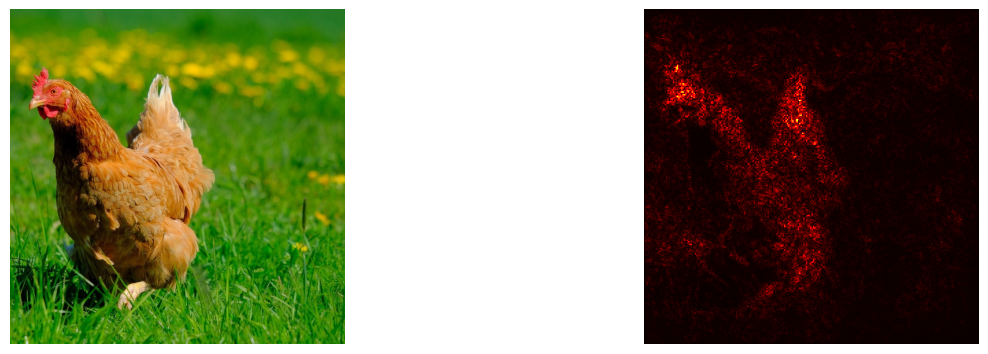

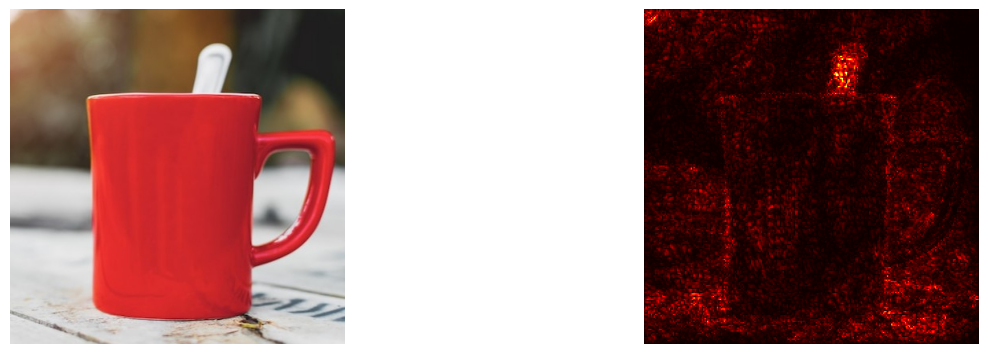

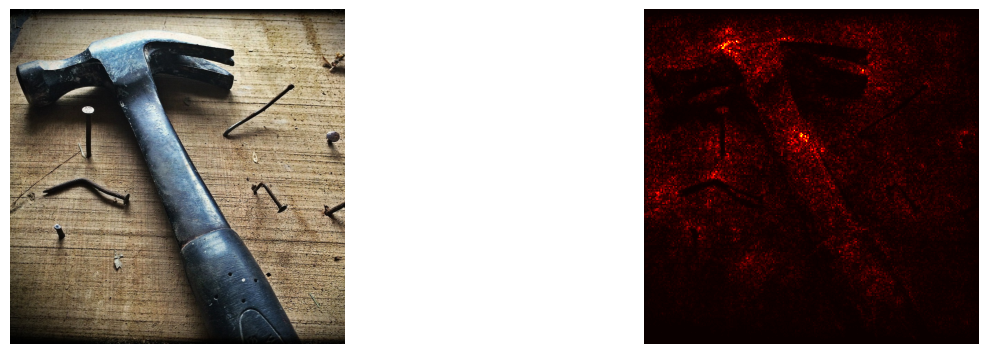

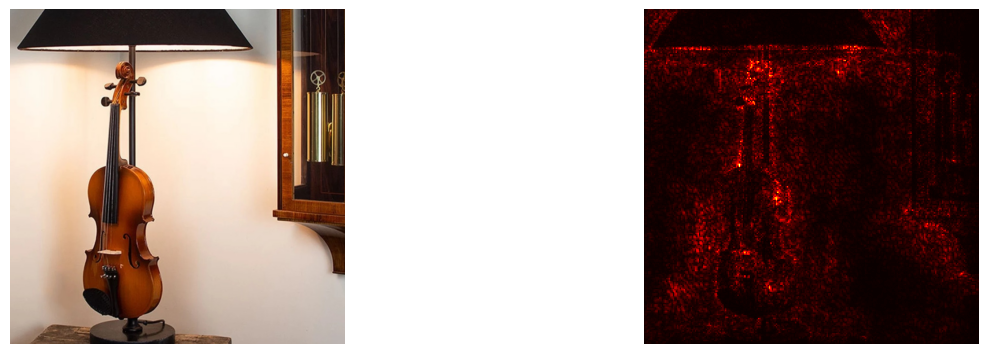

In [6]:
# Calculating and visualizing the x-gradients

for img in tqdm(image_list):
    img_path = img[0]
    img_class = img[1]
    
    # Transforming the image to tensor
    transform = transforms.Compose(
        [
            transforms.Resize((244, 244)),
            transforms.ToTensor()
        ]
    )
    image_org  = Image.open(img_path)
    image = image_org
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.requires_grad_()
    
    # Calculating the attributions
    attributions = x_gradient(image, img_class)
    
    # Plotting the original image and attributions
    plt.figure(figsize=(15,20))
    
    plt.subplot(len(image_list),2,(image_list.index(img)*2)+1)
    plt.imshow(image_org)
    plt.axis("off")
    
    plt.subplot(len(image_list),2,(image_list.index(img)*2)+2)
    plt.imshow(attributions,cmap='hot')
    plt.axis("off")

plt.show()
    
    
    
    
    

### Observing the effect of conrast of image 

100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


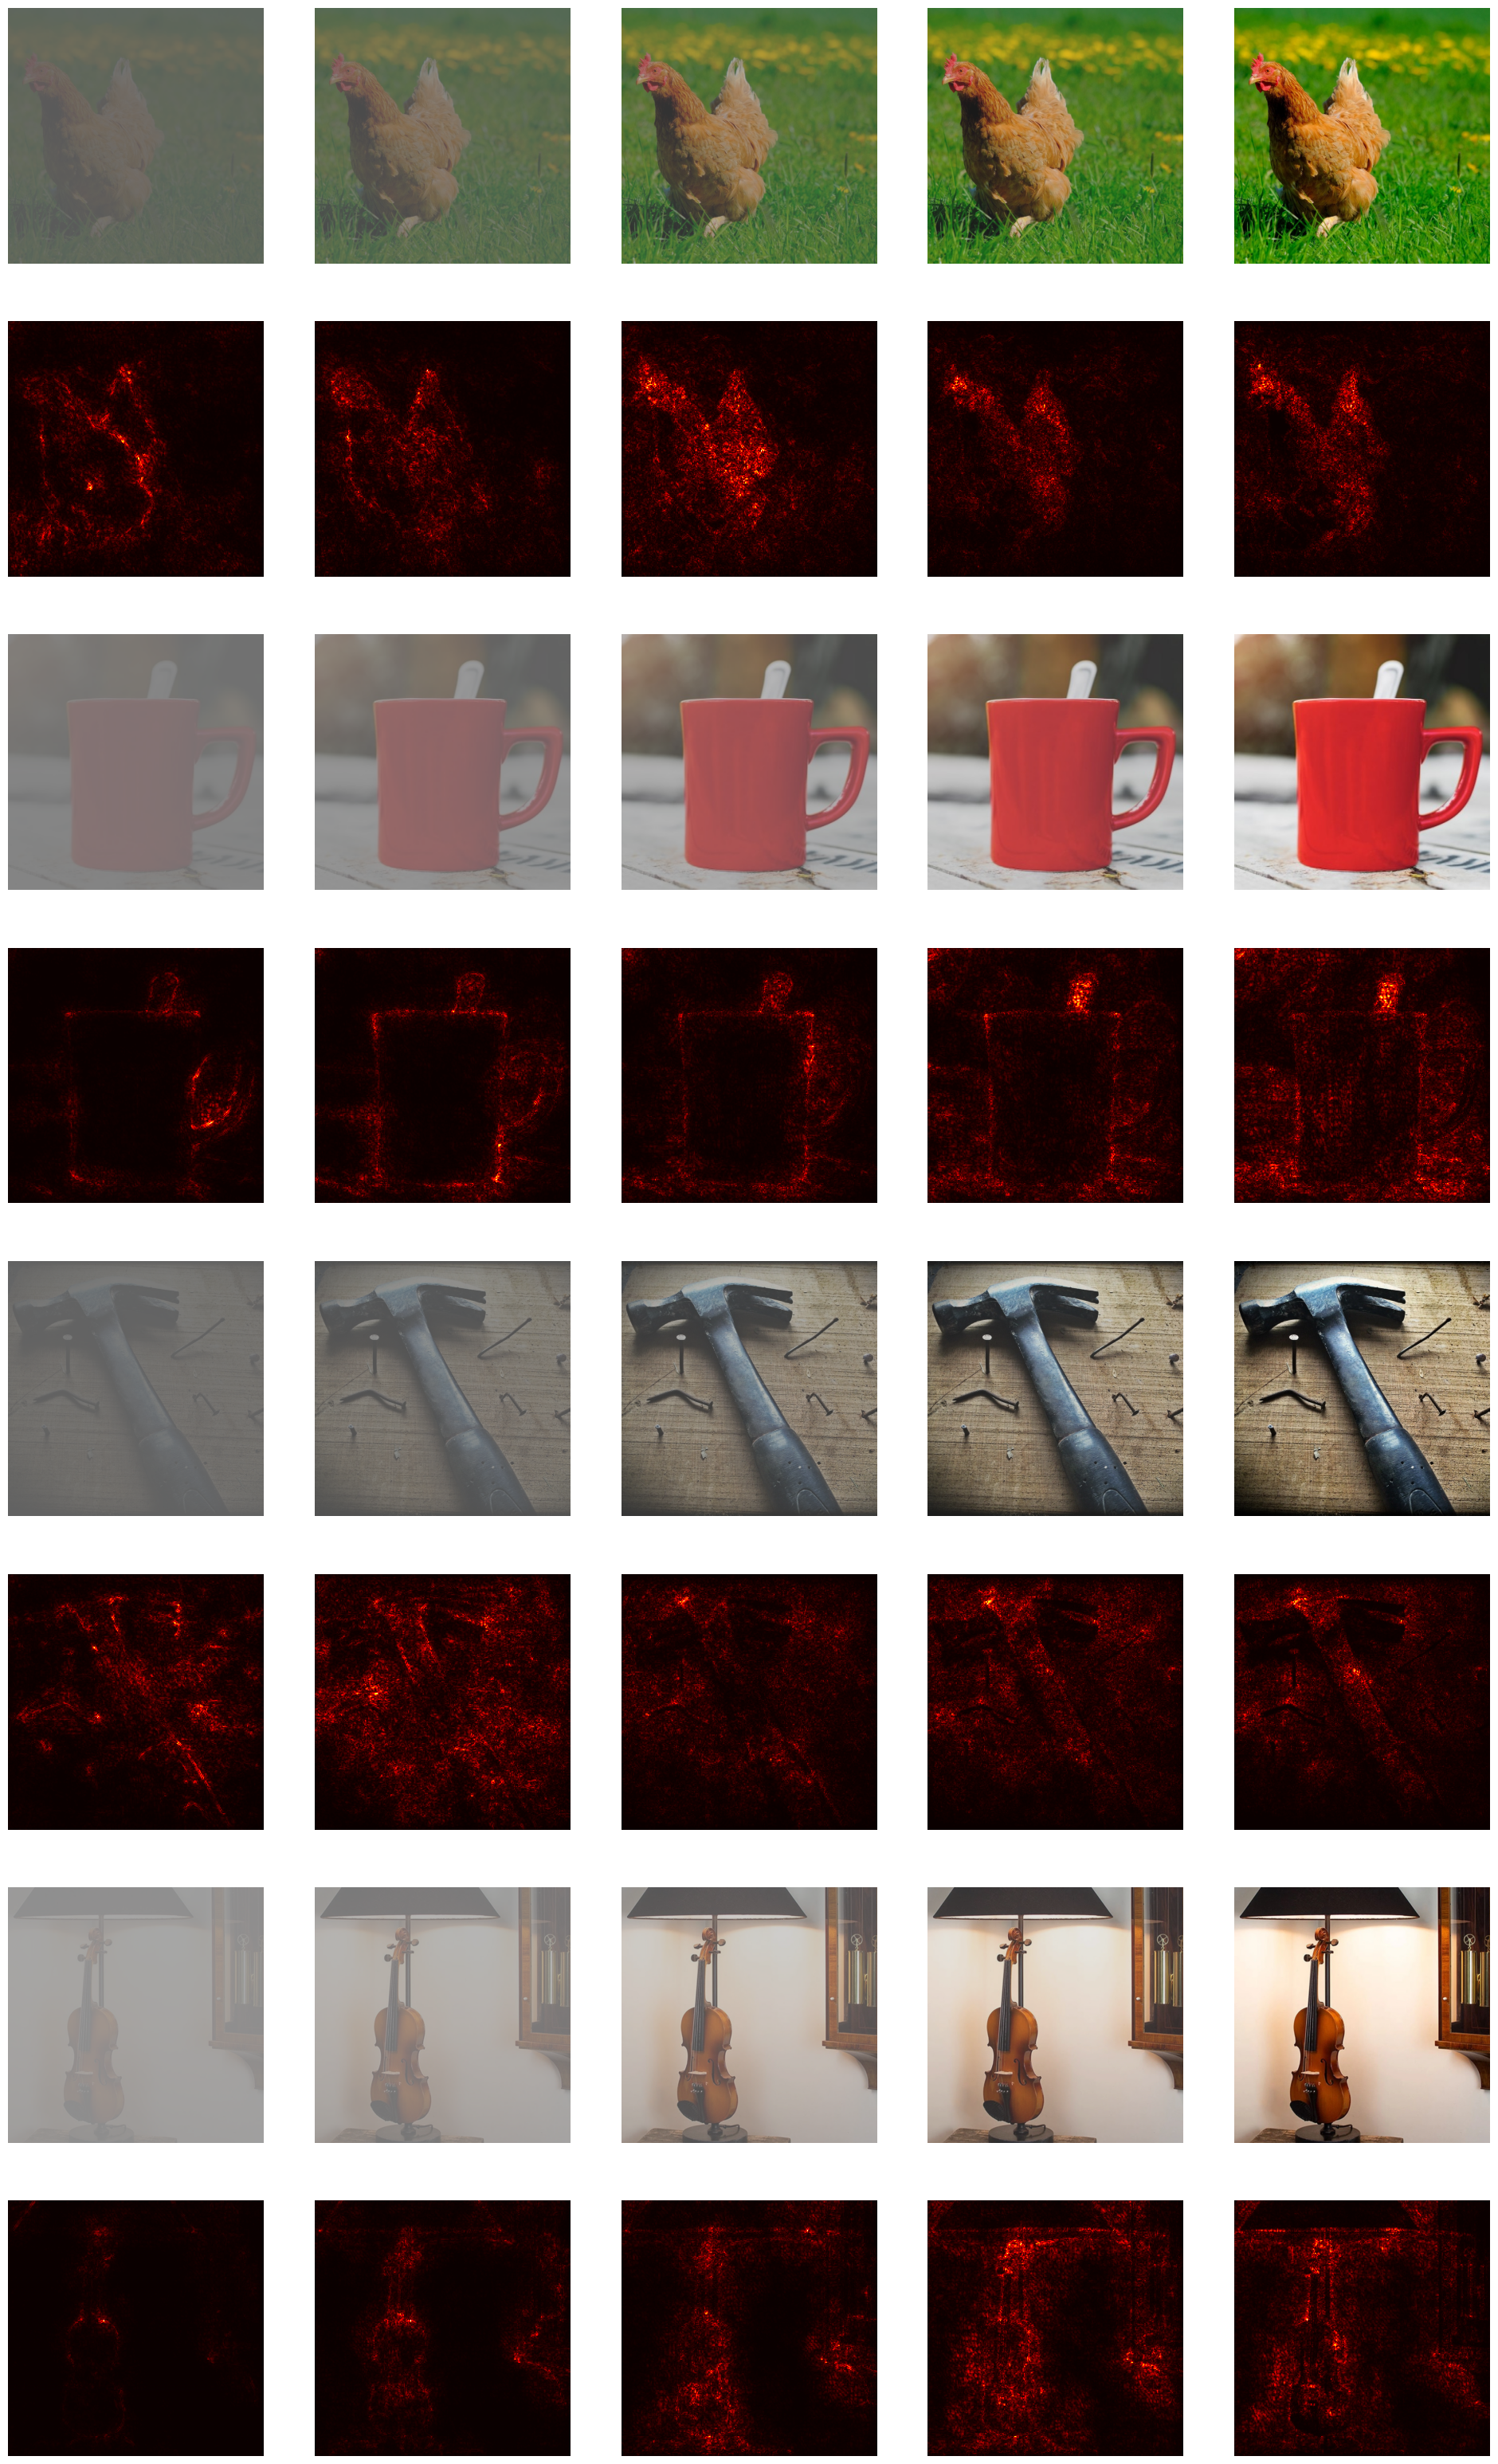

In [7]:
# varying the contrast of the image

contrasts = [0.1, 0.25, 0.5, 0.75, 1]

plt.figure(figsize=(24,40))

for cont in contrasts:
    for img in tqdm(image_list):
        img_path = img[0]
        img_class = img[1]
        
        # Transforming the image to tensor
        transform = transforms.Compose(
            [
                transforms.Resize((244, 244)),
                transforms.ToTensor()
            ]
        )
        
        image_org  = Image.open(img_path)
        image_org = TF.adjust_contrast(image_org, cont)
        image = image_org
        image = transform(image)
        image = image.unsqueeze(0)
        image = image.requires_grad_()
        
        # Calculating the attributions
        attributions = x_gradient(image, img_class)
        
        # Plotting the results
        plt.subplot(
                len(image_list)*2,
                len(contrasts),
                ((image_list.index(img) * 2) * len(contrasts)) + 1 + contrasts.index(cont)
            )
        plt.imshow(image_org)
        plt.axis("off")
        
        plt.subplot(
                len(image_list)*2,
                len(contrasts),
                (((image_list.index(img) * 2) + 1) * len(contrasts)) + 1 + contrasts.index(cont)
            )
        plt.imshow(attributions,cmap='hot')
        plt.axis("off")

plt.show()
    
    
    
    